# REFERENCES

The following resource:
https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb

Along with LLMs were used (after confirming with TA that LLM use was appropriate to aid in working with models that we did not have previous experience in).


In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/junminkim/Desktop/School/KingLabs/StrokeResearch/segment_anything


In [5]:
%pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

Note: you may need to restart the kernel to use updated packages.


In [7]:
!mkdir -p {HOME}/weights
!curl -L https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth --output ~/weights/sam_vit_h_4b8939.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file 
  0 2445M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (56) Failure writing output to destination, passed 8192 returned 4294967295


In [8]:
CHECKPOINT_PATH = './sam_vit_h_4b8939.pth'
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

./sam_vit_h_4b8939.pth ; exist: True


In [9]:
# For GPU usage
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

### Generating cropped frames

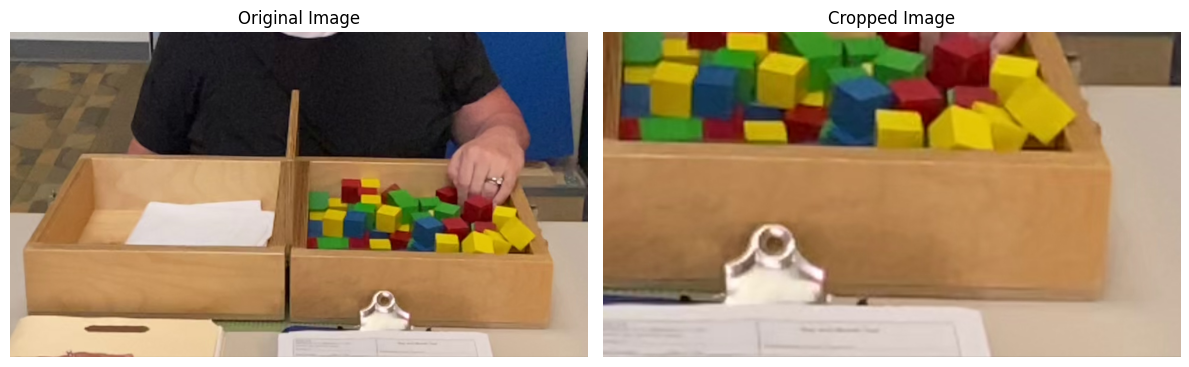

Processed and saved: cropped_frame_0000.jpg

Processed image has been saved to ./extracted_frames/cropped/


In [1]:
import os
from pathlib import Path
import cv2
import shutil
import matplotlib.pyplot as plt

def process_single_image(root_dir, output_dir):
    """
    Gets the first image found in the directory structure, crops it,
    displays it using matplotlib, and saves it to output directory.
    
    Args:
        root_dir (str): Path to the root directory containing images
        output_dir (str): Path to the output directory for cropped image
    """
    # Create output directory, removing if it already exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    root = Path(root_dir)
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
    
    # Find first image in any subdirectory
    for subdir in sorted(root.iterdir()):
        if subdir.is_dir():
            for file in sorted(subdir.iterdir()):
                if file.suffix.lower() in image_extensions:
                    # Read the image
                    image = cv2.imread(str(file))
                    if image is None:
                        print(f"Warning: Could not read image {file}")
                        continue
                    
                    # Convert BGR to RGB for matplotlib
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        
                    # Get image dimensions
                    height, width = image.shape[:2]
                    half_height = height // 2
                    half_width = width // 2
                    
                    # Crop the image (bottom-right quarter)
                    cropped = image[half_height:, half_width:, :]
                    
                    # Create a figure with two subplots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                    
                    # Display original image
                    ax1.imshow(image)
                    ax1.set_title('Original Image')
                    ax1.axis('off')
                    
                    # Display cropped image
                    ax2.imshow(cropped)
                    ax2.set_title('Cropped Image')
                    ax2.axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Convert back to BGR for saving
                    cropped_bgr = cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR)
                    
                    # Create output filename based on original filename
                    output_filename = f"cropped_{file.stem}{file.suffix}"
                    output_path = os.path.join(output_dir, output_filename)
                    
                    # Save the cropped image
                    cv2.imwrite(output_path, cropped_bgr)
                    print(f"Processed and saved: {output_filename}")
                    
                    # Return after processing first image found
                    return

root_directory = "./extracted_frames"
output_directory = "./extracted_frames/cropped"
    
process_single_image(root_directory, output_directory)

## Segmenting

In [ ]:
import os
import cv2
import numpy as np
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def get_most_salient_mask(sam_result):
    max_score = -float('inf')
    most_salient_idx = 0

    image_area = sam_result[0]['segmentation'].shape[0] * sam_result[0]['segmentation'].shape[1]

    for idx, mask_data in enumerate(sam_result):
        # Get mask properties
        mask = mask_data['segmentation']
        stability_score = mask_data['stability_score']
        pred_iou = mask_data['predicted_iou']

        # Calculate area score (normalized)
        area = mask_data['area']
        area_score = area / image_area

        # Calculate centrality score
        bbox = mask_data['bbox']  # [x, y, w, h]
        mask_center_x = bbox[0] + bbox[2]/2
        mask_center_y = bbox[1] + bbox[3]/2
        image_center_x = mask.shape[1]/2
        image_center_y = mask.shape[0]/2

        # Distance from center (normalized)
        max_dist = np.sqrt(image_center_x**2 + image_center_y**2)
        center_dist = np.sqrt((mask_center_x - image_center_x)**2 +
                            (mask_center_y - image_center_y)**2)
        centrality_score = 1 - (center_dist / max_dist)

        # Combine scores with weights
        combined_score = (
            0.3 * area_score +
            0.3 * stability_score +
            0.2 * pred_iou +
            0.2 * centrality_score
        )

        if combined_score > max_score:
            max_score = combined_score
            most_salient_idx = idx

    return most_salient_idx

def get_most_salient_mask_left(sam_result):
   """
   Determines the most salient mask based on multiple criteria:
   1. Area (larger objects are typically more salient)
   2. Stability score from SAM
   3. Predicted IOU score from SAM
   4. Proximity to target point (height/2, width/4)
   """
   max_score = -float('inf')
   most_salient_idx = 0

   # Get image dimensions
   image_height = sam_result[0]['segmentation'].shape[0]
   image_width = sam_result[0]['segmentation'].shape[1]
   image_area = image_height * image_width

   # Calculate target point coordinates
   target_x = image_width * 0.25  # 25% from left
   target_y = image_height * 0.5  # 50% from top

   # Maximum possible distance in the image (for normalization)
   max_dist = np.sqrt(image_width**2 + image_height**2)

   for idx, mask_data in enumerate(sam_result):
       # Get mask properties
       mask = mask_data['segmentation']
       stability_score = mask_data['stability_score']
       pred_iou = mask_data['predicted_iou']

       # Calculate area score (normalized)
       area = mask_data['area']
       area_score = area / image_area

       # Calculate target point proximity score
       bbox = mask_data['bbox']  # [x, y, w, h]
       mask_center_x = bbox[0] + bbox[2]/2
       mask_center_y = bbox[1] + bbox[3]/2
       
       # Distance from target point
       target_dist = np.sqrt(
           (mask_center_x - target_x)**2 + 
           (mask_center_y - target_y)**2
       )
       target_proximity_score = 1 - (target_dist / max_dist)

       # Combine scores with weights
       combined_score = (
           0.3 * area_score +
           0.2 * stability_score +
           0.2 * pred_iou +
           0.3 * target_proximity_score
       )

       if combined_score > max_score:
           max_score = combined_score
           most_salient_idx = idx

   return most_salient_idx

def process_image_for_saliency(image_path, mask_generator):
    # Read and process image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate SAM result
    sam_result = mask_generator.generate(image_rgb)

    # Get most salient mask
    # salient_idx = get_most_salient_mask(sam_result)
    salient_idx = get_most_salient_mask_left(sam_result)

    salient_result = [sam_result[salient_idx]]

    # Create annotator
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

    # Generate salient object image
    salient_detections = sv.Detections.from_sam(sam_result=salient_result)
    salient_object_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=salient_detections)

    # Create results directory in the same folder as the image
    image_dir = os.path.dirname(image_path)
    results_dir = os.path.join(image_dir, 'results')
    os.makedirs(results_dir, exist_ok=True)

    # Save result image
    image_filename = os.path.basename(image_path)
    result_filename = f"salient_{image_filename}"
    result_path = os.path.join(results_dir, result_filename)
    cv2.imwrite(result_path, salient_object_image)

    return result_path


In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

### Processing one image for testing

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def process_image_for_mask(image_path, mask_generator, output_dir):
    # Read and convert image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate SAM result and get most salient mask
    sam_result = mask_generator.generate(image_rgb)
    salient_idx = get_most_salient_mask_left(sam_result)
    salient_mask = sam_result[salient_idx]['segmentation']


    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Display original image
    ax1.imshow(image_rgb)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Display mask
    ax2.imshow(salient_mask, cmap='gray')
    ax2.set_title('Generated Mask')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Save mask
    image_filename = os.path.basename(image_path)
    mask_path = os.path.join(output_dir, f"mask_{image_filename}")
    cv2.imwrite(mask_path, salient_mask.astype(np.uint8) * 255)
    
    return mask_path

# We can see that SAM correctly bounded the side of the main box with its mask from the cropped image

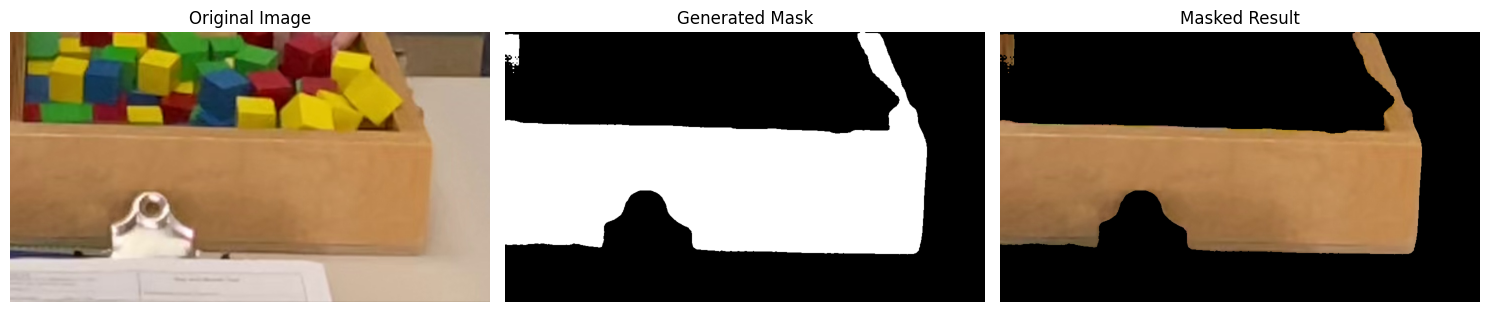

'./mask_cropped_frame_0000.jpg'

In [14]:
process_image_for_mask("./extracted_frames/cropped/cropped_frame_0000.jpg",mask_generator, "./")

# Now we apply heuristics to extract the right edge of the box from the mask

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def draw_rightmost_edge_line(mask, image_name, output_dir):
    white_pixels = np.column_stack(np.where(mask == 255))
    if white_pixels.size > 0:
        # Get rightmost pixel coordinates
        rightmost_pixel = white_pixels[white_pixels[:, 1].argmax()]
        rightmost_x, rightmost_y = rightmost_pixel[1], rightmost_pixel[0]
        
        points = [(rightmost_x, rightmost_y)]
        print(f"Starting point: ({rightmost_x}, {rightmost_y})")  # Debug print
        
        # Collect edge points
        for y in range(rightmost_y + 1, mask.shape[0]):
            row_white_pixels = np.where(mask[y] == 255)[0]
            if row_white_pixels.size > 0:
                rightmost_x_in_row = row_white_pixels[-1]
                
                tolerance = 10
                if abs(rightmost_x_in_row - points[-1][0]) <= tolerance:
                    points.append((rightmost_x_in_row, y))
                else:
                    break
            else:
                break

        # Counting pixels
        if len(points) >= 2:
            first_point = points[0]
            last_point = points[-1]
            print(f"Number of points collected: {len(points)}")  # Debug print
            distance = np.sqrt(np.sum((np.array(last_point) - np.array(first_point)) ** 2))
            filename = image_name.split(' ')[-1].split('.')[0]

            # Create a colored output image
            output_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            
            # Draw all collected points and connect them with lines
            for i in range(len(points) - 1):
                # Current point
                pt1 = points[i]
                # Next point
                pt2 = points[i + 1]
                
                # Draw line between consecutive points
                cv2.line(output_image, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0, 255, 0), thickness=2)
                
                # Draw point markers (optional - comment out if you only want the line)
                cv2.circle(output_image, (pt1[0], pt1[1]), 2, (0, 255, 0), -1)
            
            # Draw the last point
            cv2.circle(output_image, (points[-1][0], points[-1][1]), 2, (0, 255, 0), -1)

            # Display with matplotlib
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

            # Original mask
            ax1.imshow(mask, cmap='gray')
            ax1.set_title('Original Mask')
            ax1.axis('off')

            # Mask with line
            ax2.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
            ax2.set_title(f'Detected Edge Path\nPoints: {len(points)}, Length: {distance:.2f} pixels')
            ax2.axis('off')

            plt.tight_layout()
            plt.show()

        # Save output image
        output_path = os.path.join(output_dir, f"edge_{image_name}")
        cv2.imwrite(output_path, output_image)

        return output_image

# Results of SAM + Hueristics (result shown as green line)

Starting point: (843, 229)
Number of points collected: 215


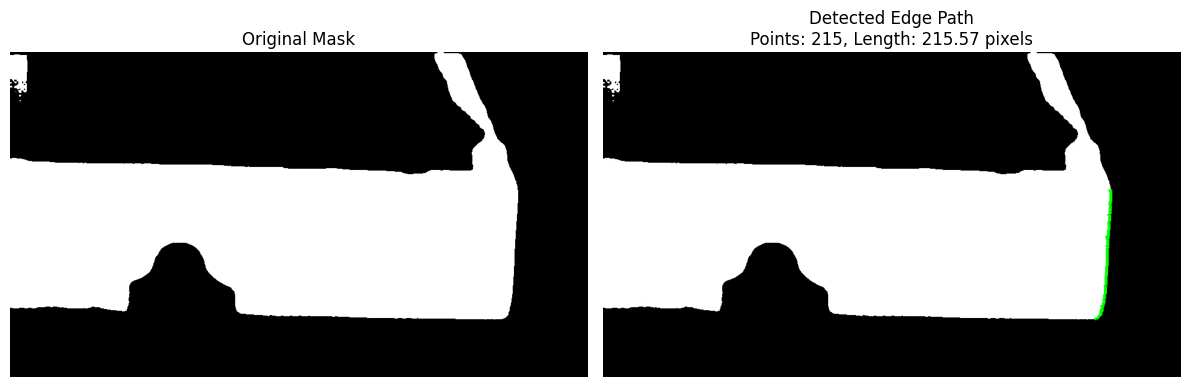

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [4, 4, 4],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [38]:
mask = cv2.imread("./mask_cropped_frame_0000.jpg", cv2.IMREAD_GRAYSCALE)
draw_rightmost_edge_line(mask, "output_with_line.jpg", "./")